In [61]:
import numpy as np
import pandas as pd
from numpy.linalg import solve
import matplotlib.pyplot as plt
from scipy.linalg import qr
from scipy import optimize
from scipy.special import erfinv
from scipy.optimize import minimize_scalar
import egrss 
import time
from scipy import integrate
import lambda_fun
import os

def pertubation(datapoint, a, b, p, yhat, x, xall, n_fit, quantile):
    """
    Making pertubations and fit
    """
    if datapoint == 'left':
        datapoint = 0
    elif datapoint == 'center':
        datapoint = int(len(yhat)/2)
    elif datapoint == 'right':
        datapoint = len(yhat)-1
    allfit = pd.DataFrame(index=range(len(xall)),columns=range(n_fit))
    val = yhat[datapoint]
    Ut, Vt = egrss.generators((x-a)/(b-a),p)

    for i in range(n_fit):
        yhat[datapoint] += sigma* np.random.normal(loc = 0, scale = 1, size = 1)

        # Finding the optimal lambda - GML
        res_GML = lambda_fun.min_GCV(N, a, b, p, yhat, 'bounded', 'min',  (1,13))
        lam = 1/np.power(10,8)
        Ut, Vt = egrss.generators((x-a)/(b-a),p)
        Utt, Vtt = egrss.generators((xall-a)/(b-a),p)
        Wt, z  = egrss.potrf(Ut,Vt,N*lam/xi)
        c,d    = lambda_fun.smoothing_spline_reg(Ut,Wt,z,yhat)
        cextra = np.zeros(len(xextra))
        ct =  np.concatenate((c,cextra),axis=0)
        yt = egrss.symv(Utt,Vtt,ct)+Utt.T@d
        yt_df = pd.DataFrame(yt)
        allfit[i] = yt_df
        yhat[datapoint] = val
    
    max_val = allfit.quantile(q=1-(1-quantile)/2, axis=1, numeric_only=True)
    med_val = allfit.quantile(q=0.5, axis=1, numeric_only=True)
    min_val = allfit.quantile(q=(1-quantile)/2, axis=1, numeric_only=True)

    return min_val, med_val, max_val, allfit, datapoint, lam

def pertubation_all(a, b, p, yhat, x, xall, n_fit, quantile):
    result_max = pd.DataFrame(index=range(len(xall)),columns=range(len(yhat)))
    result_med = pd.DataFrame(index=range(len(xall)),columns=range(len(yhat)))
    result_min = pd.DataFrame(index=range(len(xall)),columns=range(len(yhat)))
    allfit = pd.DataFrame(index=range(len(xall)),columns=range(n_fit))
    Ut, Vt = egrss.generators((x-a)/(b-a),p)

    for j in range(len(yhat)):
        val = yhat[j]
        for i in range(n_fit):
            yhat[j] += sigma* np.random.normal(loc = 0, scale = 1, size = 1)
            # Finding the optimal lambda - GML
            res_GML = lambda_fun.min_GCV(N, a, b, p, yhat, 'bounded', 'min',  (1,13))
            lam = 1/np.power(10,8)
            Ut, Vt = egrss.generators((x-a)/(b-a),p)
            Utt, Vtt = egrss.generators((xall-a)/(b-a),p)
            Wt, z  = egrss.potrf(Ut,Vt,N*lam/xi)
            c,d    = lambda_fun.smoothing_spline_reg(Ut,Wt,z,yhat)
            cextra = np.zeros(len(xextra))
            ct =  np.concatenate((c,cextra),axis=0)
            yt = egrss.symv(Utt,Vtt,ct)+Utt.T@d
            yt_df = pd.DataFrame(yt)
            allfit[i] = yt_df
            yhat[j] = val
       
        max_val = allfit.quantile(q=1-(1-quantile)/2, axis=1, numeric_only=True)
        med_val = allfit.quantile(q=0.5, axis=1, numeric_only=True)
        min_val = allfit.quantile(q=(1-quantile)/2, axis=1, numeric_only=True)
        
        max_val = pd.DataFrame(max_val)
        med_val = pd.DataFrame(med_val)
        min_val = pd.DataFrame(min_val)
    
        result_max[j] = max_val
        result_med[j] = med_val
        result_min[j] = min_val
        
    res_max = result_max.max(axis=1)
    res_med = result_med.median(axis=1)
    res_min = result_min.min(axis=1)

    return res_min, res_med, res_max


/Users/Nikoline/Documents/DTU/6. semester/Bachelor/Bachelor/lambda_fun.py:58: RuntimeWarning: divide by zero encountered in double_scalars
  xi = (b-a) ** (2 * p - 1)
<ipython-input-79-91941e235d4f>:56: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend([ax[0],ax[1]], labels=line_labels, bbox_to_anchor=(1.05, 0.74), loc="center right", borderaxespad=0.2)


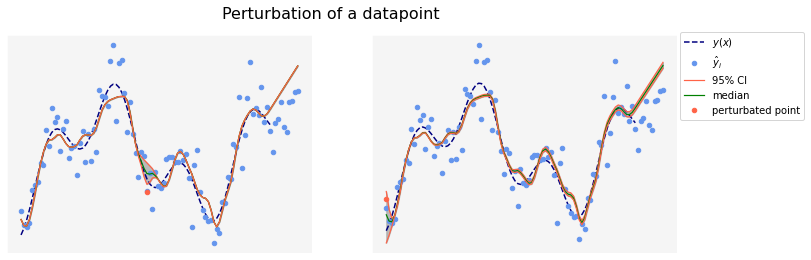

In [79]:
# Generate data with noise level sigma
N = 90
sigma = 0.1
a, b = -0.2, 0.43
p = 2  # degree of splines
xi = (b-a) ** (2 * p - 1)
x = np.linspace(a,b,N)
xextra = np.linspace(0.43,0.5,10)
xall = np.linspace(-0.2,0.5,100) 

np.random.seed(1)
yhat = lambda_fun.y(x) + sigma * np.random.normal(loc = 0, scale = 1, size = x.shape)
yall = lambda_fun.y(xall) + sigma * np.random.normal(loc = 0, scale = 1, size = xall.shape)

min_center, med_center, max_center, allfit, datapoint_center, lam_center = pertubation(datapoint='center', a=a, b=b, p=p, yhat=yhat, x=x, xall=xall, n_fit=200, quantile=0.95)
min_left, med_left, max_left, allfit, datapoint_left, lam_left = pertubation(datapoint='left', a=a, b=b, p=p, yhat=yhat, x=x, xall=xall, n_fit=200, quantile=0.95)

fig,ax = plt.subplots(1,2,figsize=(12, 4))
fig.suptitle('Perturbation of a datapoint', size=16)

ax[0].plot(x,lambda_fun.y(x),'--',color = 'navy', linewidth=1.5)
ax[0].plot(xall,yall,'o',markersize = 4.5, color = 'cornflowerblue')
ax[0].plot(xall,max_center,color = 'tomato', linewidth=1.2)
ax[0].plot(xall,med_center,color = 'green', linewidth=1.2)
ax[0].plot(x[datapoint_center], yhat[datapoint_center], 'o',markersize=4.5, color='tomato')
ax[0].fill_between(xall, min_center, max_center, color='grey', alpha=0.5)
ax[0].plot(xall,min_center,color = 'tomato', linewidth=1.2)
ax[0].xaxis.set_visible(False)
ax[0].yaxis.set_visible(False)
ax[0].spines['bottom'].set_color('white')
ax[0].spines['top'].set_color('white') 
ax[0].spines['right'].set_color('white')
ax[0].spines['left'].set_color('white')
ax[0].set_facecolor('whitesmoke')
ax[0].tick_params(left=False, bottom = False, right = False, top = False)
ax[0] = plt.gca()
    
ax[1].plot(x,lambda_fun.y(x),'--',color = 'navy', linewidth=1.5)
ax[1].plot(xall,yall,'o',markersize = 4.5, color = 'cornflowerblue')
ax[1].plot(xall,max_left,color = 'tomato', linewidth=1.2)
ax[1].plot(xall,med_left,color = 'green', linewidth=1.2)
ax[1].plot(x[datapoint_left], yhat[datapoint_left], 'o',markersize=4.5, color='tomato')
ax[1].fill_between(xall, min_left, max_left, color='grey', alpha=0.5)
ax[1].plot(xall,min_left,color = 'tomato', linewidth=1.2)
ax[1].xaxis.set_visible(False)
ax[1].yaxis.set_visible(False)
ax[1].tick_params(left=False, bottom = False, right = False, top = False)
ax[1] = plt.gca()
ax[1].spines['bottom'].set_color('white')
ax[1].spines['top'].set_color('white') 
ax[1].spines['right'].set_color('white')
ax[1].spines['left'].set_color('white')
ax[1].set_facecolor('whitesmoke')

line_labels = ["$y(x)$", "$\hat{y}_i$", "95% CI", "median", "perturbated point"]
fig.legend([ax[0],ax[1]], labels=line_labels, bbox_to_anchor=(1.05, 0.74), loc="center right", borderaxespad=0.2)
my_path = os.getcwd()
fig.savefig(my_path + "/Plots/perturbation_onepoint.pdf", bbox_inches='tight')


# Plotting the model generated with lambda_GML
#fig2 = plt.figure()
#plt.plot(x,lambda_fun.y(x),'--',color = 'navy', linewidth=1.5)
#plt.plot(xall,yall,'o',markersize = 4.5, color = 'cornflowerblue')
#plt.plot(xall,max_val,color = 'tomato', linewidth=1.2)
#plt.plot(xall,med_val,color = 'green', linewidth=1.2)
#plt.plot(x[datapoint], yhat[datapoint], 'o',markersize=4.5, color='tomato')
#plt.fill_between(xall, min_val, max_val, color='grey', alpha=0.5)
#plt.plot(xall,min_val,color = 'tomato', linewidth=1.2)
#plt.xticks([])
#plt.yticks([])
#plt.xlim([a-0.07,b+0.07])
#plt.tick_params(left=False, bottom = False, right = False, top = False)
#plt.legend(['$y(x)$', '$\hat{y}_i$','model'], numpoints = 1, prop = {'size': 14}, loc = 0)
#ax = plt.gca()
#ax.set_facecolor('whitesmoke')
#for spine in plt.gca().spines.values():
#    spine.set_visible(False)
# plt.title('Fit - pertubating a point', fontsize = 18)
#plt.show()
#fig2.savefig("pertubation_center.pdf", bbox_inches='tight')

/Users/Nikoline/Documents/DTU/6. semester/Bachelor/Bachelor/lambda_fun.py:58: RuntimeWarning: divide by zero encountered in double_scalars
  xi = (b-a) ** (2 * p - 1)


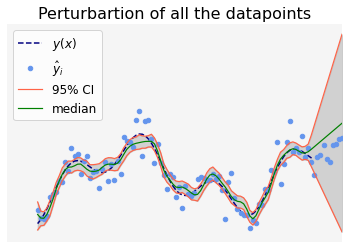

In [69]:
res_min, res_med, res_max = pertubation_all(a=a, b=b, p=p, yhat=yhat, x=x, xall=xall, n_fit=200, quantile=0.95)

# Plotting the model generated with lambda_GML
fig2 = plt.figure()
plt.plot(x,lambda_fun.y(x),'--',color = 'navy', linewidth=1.5)
plt.plot(xall,yall,'o',markersize = 4.5, color = 'cornflowerblue')
plt.plot(xall,res_max,color = 'tomato', linewidth=1.2)
plt.plot(xall,res_med,color = 'green', linewidth=1.2)
plt.fill_between(xall, res_min, res_max, color='grey', alpha=0.3)
plt.plot(xall,res_min,color = 'tomato', linewidth=1.2)
plt.xticks([])
plt.yticks([])
plt.xlim([a-0.07,b+0.07])
plt.tick_params(left=False, bottom = False, right = False, top = False)
plt.legend(['$y(x)$', '$\hat{y}_i$','95% CI', 'median'], numpoints = 1, prop = {'size': 12}, loc = 0)
plt.title("Perturbartion of all the datapoints", fontsize=16)
ax = plt.gca()
ax.set_facecolor('whitesmoke')
for spine in plt.gca().spines.values():
    spine.set_visible(False)
# plt.title('Fit - pertubating a point', fontsize = 18)
plt.show()
my_path = os.getcwd()
fig2.savefig(my_path + "/Plots/pertubation_all.pdf", bbox_inches='tight')
